# Machine Learning for String Field Theory

H. Erbin, R. Finotello, M. Kudrna, M. Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we use the datasets for training and predicting the extrapolated labels using automatic optimisation of the hyperparameters.

## General Observations

In general the predicted labels should be better than fine level truncations.
For this reason the metric we use is the difference between the extrapolated label and the prediction (the *residual*) as compared to the same difference with the last truncation level.
Namely we use the ratio *R* defined as:
\begin{equation}
R = \frac{1}{N} \sum\limits_{i = 1}^N \left| \frac{y^{(i)} - y^{(i)}_{pred}}{y^{(i)} - y^{(i)}_{finite}} \right|,
\end{equation}
where $y_{finite}$ is the value of the label in the last finite truncation level, while $y_{pred}$ is the predicted label.
This way $R \to 0$ would identify an overall better result than finite level truncations.

## Lump Solutions

We first focus on the lumps solutions and retain the double lumps as external test set (we may need to rescale the labels in that case).

In [1]:
import pandas as pd

lumps = pd.read_csv('./data/lumps.csv')

In [2]:
import numpy as np

def metric(y_true, y_pred, finite_res):
    '''
    Measure the ratio between finite level truncation and the predictions.
    
    Arguments:
    
        y_true:     the true values,
        y_pred:     the predicted values,
        finite_res: the finite level truncation residues.
        
    Returns:
    
        the average ratio of the residuals.
    '''
    if type(y_true) is list:
        y_true = np.array(y_true)
    if type(y_pred) is list:
        y_pred = np.array(y_pred)
    if type(finite_res) is list:
        finite_res = np.array(finite_res)
        
    pred_res = y_true - y_pred
    ratio    = np.abs(finite_res / pred_res)
    
    return -np.mean(ratio)

We then add a column containing the difference between the last truncation level and the extrapolated label (i.e. the *residual* of the finite level truncation).
We then keep only a selected amount of data for the analysis, namely entries whose finite residue is less than $1$.

In [3]:
import numpy as np

finite_res          = np.abs(lumps['level_18'] - lumps['exp'])
lumps['finite_res'] = finite_res

# keep only samples whit finite residue less than the unit
lumps = lumps.loc[lumps['finite_res'] < 1.0]
lumps.describe()

,solutions,init,exp,weight,type,level_2,level_3,level_4,level_5,level_6,...,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18,finite_res
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,...,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,24.031630,0.780427,0.576642,0.454762,3.552311,0.353071,0.400899,0.643048,0.691333,0.572673,...,0.594053,0.548343,0.558022,0.598197,0.594774,0.559959,0.559882,0.591446,0.592596,0.090143
std,13.221249,0.983556,0.674149,0.517978,0.834654,0.715453,0.806383,0.653024,0.670049,0.793520,...,0.759515,0.740592,0.655784,0.671630,0.729364,0.717390,0.653724,0.664339,0.712717,0.196353
min,0.000000,0.000000,-1.000000,0.000000,2.000000,-1.979127,-2.258389,-0.754568,-0.782633,-1.864683,...,-1.454622,-1.503910,-0.946296,-0.946943,-1.108879,-1.134510,-0.962387,-0.962334,-1.062036,0.000000
25%,13.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.008245,0.012453,0.005025,...,0.002473,0.002298,0.032866,0.032959,0.001552,0.001464,0.033380,0.039582,0.001091,0.005139
50%,25.000000,0.000000,1.000000,0.250050,4.000000,0.185270,0.889772,0.925296,0.936937,0.938467,...,0.963070,0.970162,0.977072,0.976881,0.973830,0.977599,0.982493,0.982842,0.980331,0.017888
75%,35.500000,1.575000,1.000000,0.956492,4.000000,1.000538,1.060318,1.044229,1.033921,1.014672,...,1.008573,1.008513,1.008920,1.008619,1.006120,1.005358,1.005960,1.005955,1.004860,0.044435
max,45.000000,3.000000,1.000000,4.000000,4.000000,1.239384,1.358098,2.102943,2.229147,2.212833,...,2.362696,2.409660,2.017490,2.038123,2.175909,2.203373,2.018140,2.044010,1.978923,0.978923


We then divide features and labels.

In [4]:
# divide features and labels
X  = lumps.drop(columns=['exp'])
y  = lumps['exp']

In general we will keep 80% of the data for training, 10% for validation and 10% for testing purposes:

In [5]:
from sklearn.model_selection import train_test_split

RAND = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=RAND)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=RAND)

In [6]:
X_train.to_csv('./data/X_train_lumps.csv', index=False)
X_val.to_csv('./data/X_val_lumps.csv', index=False)
X_test.to_csv('./data/X_test_lumps.csv', index=False)

y_train.to_csv('./data/y_train_lumps.csv', index=False)
y_val.to_csv('./data/y_val_lumps.csv', index=False)
y_test.to_csv('./data/y_test_lumps.csv', index=False)

### Linear Regression

We first use a simple linear regression with $\ell_2$ regularisation as a baseline computation.

In [7]:
from sklearn.linear_model import Ridge
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Real(1.0e-3, 1.0e1, prior='log-uniform', name='alpha'),
                 Integer(0, 1, name='fit_intercept'),
                 Integer(0, 1, name='normalize')
                ]
estimator = Ridge(random_state=RAND)

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['solutions', 'init', 'finite_res']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))
    
    # return the metric
    return metric(y_val.values.reshape(-1,),
                  y_val_pred.reshape(-1,),
                  X_val['finite_res'].values.reshape(-1,)
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimisation took 515.163 seconds


In [8]:
# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip(names, results.x)), index=['values'])

,alpha,fit_intercept,normalize
values,0.975287,0,1


In [9]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/ridge_lumps.pkl']

In [10]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'

# compute predictions
predictions = {'training':   list(estimator.predict(X_train.drop(columns=['solutions', 'init', 'finite_res']))),
               'validation': list(estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))),
               'test':       list(estimator.predict(X_test.drop(columns=['solutions', 'init', 'finite_res'])))
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training':   list(y_train.values.reshape(-1,) - np.array(predictions['training'])),
               'validation': list(y_val.values.reshape(-1,) - np.array(predictions['validation'])),
               'test':       list(y_test.values.reshape(-1,) - np.array(predictions['test']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error':  [mse(y_train.values.reshape(-1,), predictions['training']),
                                   mse(y_val.values.reshape(-1,), predictions['validation']),
                                   mse(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'mean_absolute_error': [mae(y_train.values.reshape(-1,), predictions['training']),
                                   mae(y_val.values.reshape(-1,), predictions['validation']),
                                   mae(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'r2_score':            [r2(y_train.values.reshape(-1,), predictions['training']),
                                   r2(y_val.values.reshape(-1,), predictions['validation']),
                                   r2(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'res_ratio':           [metric(y_train.values.reshape(-1,), predictions['training'], X_train['finite_res'].values.reshape(-1,)),
                                   metric(y_val.values.reshape(-1,), predictions['validation'], X_val['finite_res'].values.reshape(-1,)),
                                   metric(y_test.values.reshape(-1,), predictions['test'], X_test['finite_res'].values.reshape(-1,))
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error,mean_absolute_error,r2_score,res_ratio
training,0.013235,0.033674,0.969228,-17.154040
validation,0.020516,0.038950,0.965234,-692.323015
test,0.033635,0.055845,0.930768,-683.313156


We finally plot the residuals:

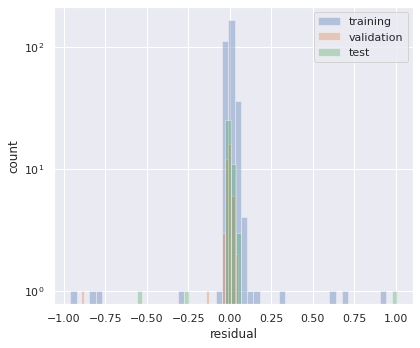

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_hist.pdf', dpi=150, format='pdf')

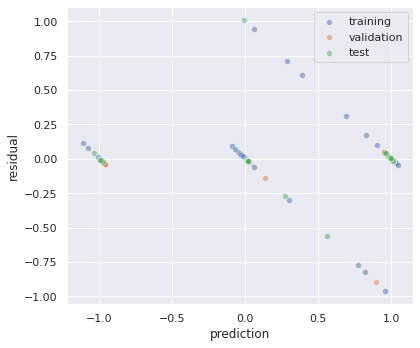

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation'],
                y=residuals['validation'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction',
       ylabel='residual'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_res.pdf', dpi=150, format='pdf')

### Support Vector Machines

We use the *kernel trick* (with a *radial basis function*) and SVM to produce the predictions.

In [13]:
from sklearn.svm import SVR
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Real(1.0e-4, 1.0e1, prior='log-uniform', name='gamma'),
                 Real(1.0e-2, 1.0e2, prior='log-uniform', name='C'),
                 Real(1.0e-4, 1.0e-1, prior='log-uniform', name='epsilon')
                ]
estimator = SVR(kernel='rbf')

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['solutions', 'init', 'finite_res']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))
    
    # return the metric
    return metric(y_val.values.reshape(-1,),
                  y_val_pred.reshape(-1,),
                  X_val['finite_res'].values.reshape(-1,)
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

Optimisation took 511.274 seconds


In [14]:
# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip(names, results.x)), index=['values'])

,gamma,C,epsilon
values,0.012124,4.105537,0.001322


In [15]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/svr_lumps.pkl']

In [16]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'

# compute predictions
predictions = {'training':   list(estimator.predict(X_train.drop(columns=['solutions', 'init', 'finite_res']))),
               'validation': list(estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))),
               'test':       list(estimator.predict(X_test.drop(columns=['solutions', 'init', 'finite_res'])))
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training':   list(y_train.values.reshape(-1,) - np.array(predictions['training'])),
               'validation': list(y_val.values.reshape(-1,) - np.array(predictions['validation'])),
               'test':       list(y_test.values.reshape(-1,) - np.array(predictions['test']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error':  [mse(y_train.values.reshape(-1,), predictions['training']),
                                   mse(y_val.values.reshape(-1,), predictions['validation']),
                                   mse(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'mean_absolute_error': [mae(y_train.values.reshape(-1,), predictions['training']),
                                   mae(y_val.values.reshape(-1,), predictions['validation']),
                                   mae(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'r2_score':            [r2(y_train.values.reshape(-1,), predictions['training']),
                                   r2(y_val.values.reshape(-1,), predictions['validation']),
                                   r2(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'res_ratio':           [metric(y_train.values.reshape(-1,), predictions['training'], X_train['finite_res'].values.reshape(-1,)),
                                   metric(y_val.values.reshape(-1,), predictions['validation'], X_val['finite_res'].values.reshape(-1,)),
                                   metric(y_test.values.reshape(-1,), predictions['test'], X_test['finite_res'].values.reshape(-1,))
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error,mean_absolute_error,r2_score,res_ratio
training,0.015080,0.022900,0.964938,-174.578266
validation,0.024831,0.033195,0.957923,-107.233424
test,0.037036,0.058045,0.923768,-38.372642


We finally plot the residuals:

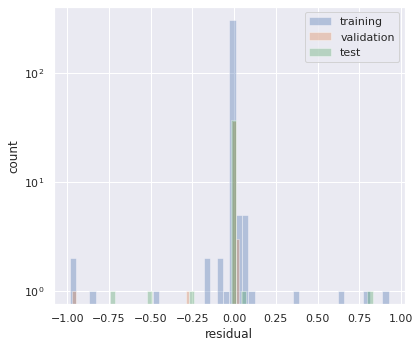

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_hist.pdf', dpi=150, format='pdf')

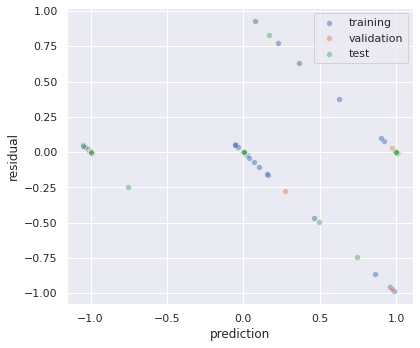

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation'],
                y=residuals['validation'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction',
       ylabel='residual'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_res.pdf', dpi=150, format='pdf')

### Gradient Boosted Decision Trees

We use gradient boosting to predict the extrapolated labels using decision trees.

In [19]:
from lightgbm import LGBMRegressor
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Integer(2, 25, name='num_leaves'),
                 Integer(2, 25, name='max_depth'),
                 Real(1e-3, 1e-1, prior='log-uniform', name='learning_rate'),
                 Integer(1e2, 1e4, prior='log-uniform', name='n_estimators'),
                 Real(0.8, 0.999, name='subsample'),
                 Real(0.7, 1.0, name='colsample_bytree'),
                 Real(1.0e-3, 1.0e-1, prior='log-uniform', name='min_child_weight'),
                 Real(1.0e0, 1.0e2, prior='log-uniform', name='reg_alpha'),
                 Real(1.0e0, 1.0e3, prior='log-uniform', name='reg_lambda')
                ]
estimator = LGBMRegressor(boosting_type='gbdt',
                          objective='regression',
                          subsample_freq=1,
                          n_jobs=-1,
                          importance_type='gain'
                         )

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['solutions', 'init', 'finite_res']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))
    
    # return the metric
    return metric(y_val.values.reshape(-1,),
                  y_val_pred.reshape(-1,),
                  X_val['finite_res'].values.reshape(-1,)
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimisation took 820.015 seconds


In [20]:
# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip(names, results.x)), index=['values'])

,num_leaves,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda
values,10,24,0.029238,9463,0.838614,0.836243,0.001337,1.433305,623.076034


In [21]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/lgbmregressor_lumps.pkl']

In [22]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'

# compute predictions
predictions = {'training':   list(estimator.predict(X_train.drop(columns=['solutions', 'init', 'finite_res']))),
               'validation': list(estimator.predict(X_val.drop(columns=['solutions', 'init', 'finite_res']))),
               'test':       list(estimator.predict(X_test.drop(columns=['solutions', 'init', 'finite_res'])))
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training':   list(y_train.values.reshape(-1,) - np.array(predictions['training'])),
               'validation': list(y_val.values.reshape(-1,) - np.array(predictions['validation'])),
               'test':       list(y_test.values.reshape(-1,) - np.array(predictions['test']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error':  [mse(y_train.values.reshape(-1,), predictions['training']),
                                   mse(y_val.values.reshape(-1,), predictions['validation']),
                                   mse(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'mean_absolute_error': [mae(y_train.values.reshape(-1,), predictions['training']),
                                   mae(y_val.values.reshape(-1,), predictions['validation']),
                                   mae(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'r2_score':            [r2(y_train.values.reshape(-1,), predictions['training']),
                                   r2(y_val.values.reshape(-1,), predictions['validation']),
                                   r2(y_test.values.reshape(-1,), predictions['test'])
                                  ],
           'res_ratio':           [metric(y_train.values.reshape(-1,), predictions['training'], X_train['finite_res'].values.reshape(-1,)),
                                   metric(y_val.values.reshape(-1,), predictions['validation'], X_val['finite_res'].values.reshape(-1,)),
                                   metric(y_test.values.reshape(-1,), predictions['test'], X_test['finite_res'].values.reshape(-1,))
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error,mean_absolute_error,r2_score,res_ratio
training,0.429803,0.558625,0.000671,-0.180294
validation,0.606926,0.645204,-0.028470,-0.210927
test,0.487712,0.587390,-0.003878,-0.269634


We finally plot the residuals:

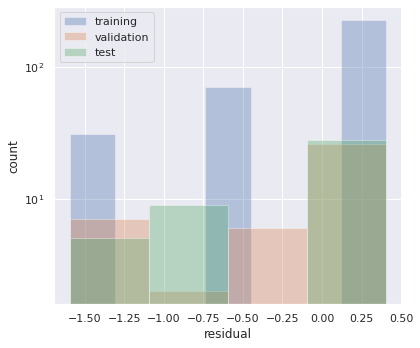

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_hist.pdf', dpi=150, format='pdf')

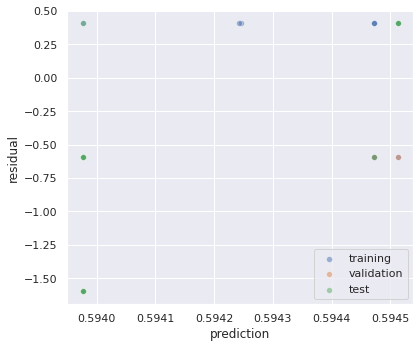

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation'],
                y=residuals['validation'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction',
       ylabel='residual'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_res.pdf', dpi=150, format='pdf')

### Neural Networks

We finally use a fully connected ANN built using Keras.

In [25]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Convert everything to tensor and build the model.

In [26]:
import os
os.makedirs('./models', exist_ok=True)

In [27]:
X_train_nn = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_nn   = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test_nn  = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train_nn = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_nn   = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test_nn  = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [28]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

# reset graph
tf.keras.backend.clear_session()
tf.random.set_seed(RAND)

# define the input shape
input_shape = X_train_nn[:,2:-1].shape[1:]

# build the model
I = Input(shape=input_shape)
x = I

x = Dense(30, activation='relu')(x)
x = Dropout(rate=0.03)(x)
x = Dense(30, activation='relu')(x)
x = Dropout(rate=0.03)(x)
x = Dense(10, activation='relu')(x)
#x = Dense(10, activation='relu')(x)

# output layers
O = Dense(1, name='exp')(x)

# create the model
model = Model(inputs=I, outputs=O, name='lumps_model')

In [29]:
import json
import os

os.makedirs('./models', exist_ok=True)
with open('./models/ann_lumps.json', 'w') as ann:
    json.dump(model.to_json(), ann)

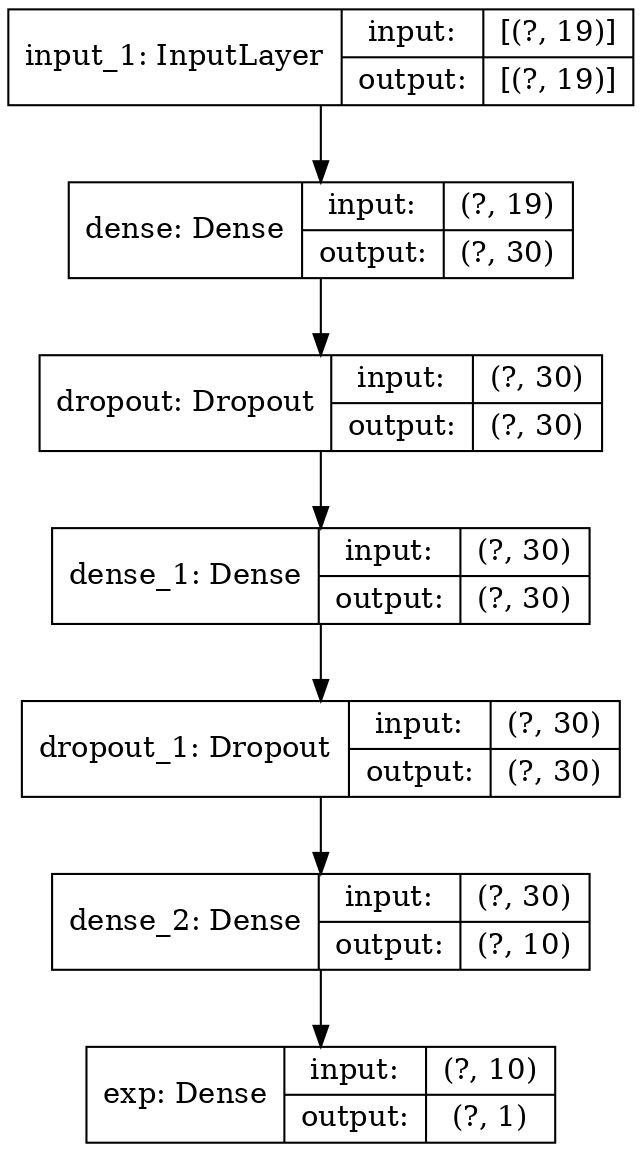

In [30]:
import os
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

os.makedirs('./img', exist_ok=True)
model_dot = model_to_dot(model, show_shapes=True, dpi=150)
model_dot.write_pdf('./img/ann_lumps_arch.pdf')

Image(model_dot.create_png(), width=320)

We then prepare the dataset objects:

In [31]:
import tensorflow as tf

BATCH_SIZE = 32
train = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn)).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
val   = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn)).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
test  = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_nn))

We then proceed with the definition of the loss function in terms of *Tensorflow* tensors:

In [32]:
import tensorflow as tf

def ratio_loss(y_true, y_pred, fin_res):
    '''
    Compute the loss using tensors.
    
    Arguments:
    
        y_true:   true values,
        y_pred:   predicted values,
        fin_res:  values of the residuals of the finite truncation levels.
    '''
    
    pred_res = tf.math.subtract(y_true, y_pred)
    ratio    = tf.math.abs(tf.math.divide(fin_res, pred_res))
    
    return -tf.math.reduce_mean(ratio)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-5)

We then use the **mean squared error** for backpropagating and updating the weights.
We however evaluate the netowrk on the residual ratio.

In [34]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        y_pred = model(x[:,2:-1], training=True)
        res    = ratio_loss(y, y_pred, x[:,-1])
        mse    = tf.keras.losses.MeanSquaredError()(y, y_pred)
        mae    = tf.keras.losses.MeanAbsoluteError()(y, y_pred)
        
    grad = tape.gradient(mse, model.trainable_weights)
    #grad = [(tf.clip_by_value(g, -1.0e6, 1.0e6)) for g in grad]
    optimizer.apply_gradients(zip(grad, model.trainable_weights))
        
    return {'residual_ratio': res,
            'mean_squared_error': mse,
            'mean_absolute_error': mae
           }

In [35]:
@tf.function
def test_step(x, y):
    
    with tf.GradientTape() as tape:
        y_pred = model(x[:,2:-1], training=False)
        res    = ratio_loss(y, y_pred, x[:,-1])
        mse    = tf.keras.losses.MeanSquaredError()(y, y_pred)
        mae    = tf.keras.losses.MeanAbsoluteError()(y, y_pred)
        
    return {'residual_ratio': res,
            'mean_squared_error': mse,
            'mean_absolute_error': mae
           }

We finally train the model:

In [36]:
EPOCHS = 50000

In [37]:
from tqdm import trange
import numpy as np

def train_loop(dataset):
    
    # store metrics and losses
    metrics = {'training_residual_ratio':   [],
               'validation_residual_ratio': [],
               'training_mse': [],
               'validation_mse': [],
               'training_mae': [],
               'validation_mae': []
              }
    
    best_val_loss = np.inf
    
    with trange(EPOCHS, desc='Training epochs', unit='epochs') as pbar:
        
        for epoch in pbar:
            
            # save metrics for each batch
            train_res_epoch = []
            val_res_epoch   = []
            
            train_mse_epoch  = []
            val_mse_epoch    = []
            
            train_mae_epoch  = []
            val_mae_epoch    = []
            
            for (x, y) in train:
                train_metrics = train_step(x, y)
                train_res_epoch.append(train_metrics['residual_ratio'])
                train_mse_epoch.append(train_metrics['mean_squared_error'])
                train_mae_epoch.append(train_metrics['mean_absolute_error'])
            for (x, y) in val:
                val_metrics = test_step(x, y)
                val_res_epoch.append(val_metrics['residual_ratio'])
                val_mse_epoch.append(val_metrics['mean_squared_error'])
                val_mae_epoch.append(val_metrics['mean_absolute_error'])
            
            # update the bar
            epoch_metrics = {'res': float(tf.math.reduce_mean(train_res_epoch)),
                             'mse': float(tf.math.reduce_mean(train_mse_epoch)),
                             'mae': float(tf.math.reduce_mean(train_mae_epoch)),
                             'val_res': float(tf.math.reduce_mean(val_res_epoch)),
                             'val_mse': float(tf.math.reduce_mean(val_mse_epoch)),
                             'val_mae': float(tf.math.reduce_mean(val_mae_epoch))
                            }
            pbar.set_postfix(epoch_metrics)
            
            # save best model
            if epoch_metrics['val_res'] < best_val_loss:
                best_val_loss = epoch_metrics['val_res']
                model.save_weights('./models/ann_lumps.h5')
                
            # add metrics for each epoch
            metrics['training_residual_ratio'].append(epoch_metrics['res'])
            metrics['training_mse'].append(epoch_metrics['mse'])
            metrics['training_mae'].append(epoch_metrics['mae'])
            metrics['validation_residual_ratio'].append(epoch_metrics['val_res'])
            metrics['validation_mse'].append(epoch_metrics['val_mse'])
            metrics['validation_mae'].append(epoch_metrics['val_mae'])
            
    return metrics

In [38]:
history = train_loop(train)
model.load_weights('./models/ann_lumps.h5')

Training epochs: 100%|██████████| 50000/50000 [14:21<00:00, 58.05epochs/s, res=-21.2, mse=0.00164, mae=0.0183, val_res=-1.59, val_mse=0.00556, val_mae=0.0398]   


In [39]:
import json
import os

os.makedirs('./predictions', exist_ok=True)
with open('./predictions/ann_history.json', 'w') as hist:
    json.dump(history, hist)

We can finally show the loss function:

In [40]:
window = int(0.01 * EPOCHS)
moving_avg = {k: np.convolve(v, np.ones((window,)) / window, mode='valid') for k, v in history.items()}

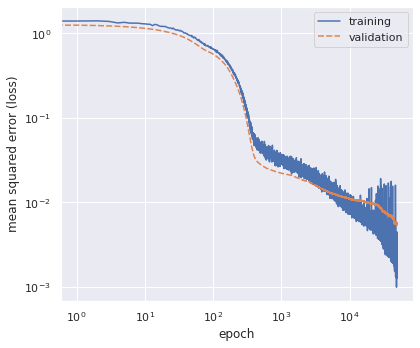

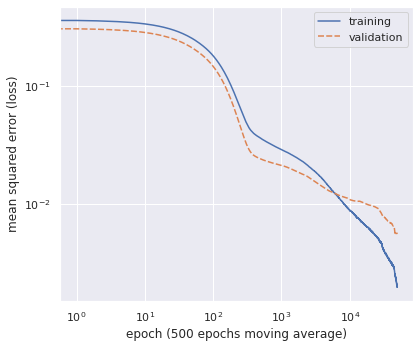

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./img', exist_ok=True)
sns.set()

data = pd.DataFrame(history)
data_avg = pd.DataFrame(moving_avg)

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data[['training_mse', 'validation_mse']],
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='mean squared error (loss)',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')

plt.tight_layout()
plt.savefig('./img/ann_loss.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data_avg[['training_mse', 'validation_mse']],
             ax=ax
            )
ax.set(title='',
       xlabel=f'epoch ({window:d} epochs moving average)',
       ylabel='mean squared error (loss)',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')

plt.tight_layout()
plt.savefig('./img/ann_loss_lumps_avg.pdf', dpi=150, format='pdf')

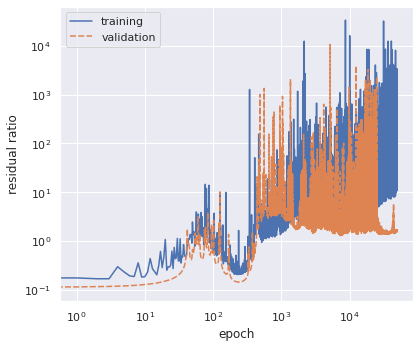

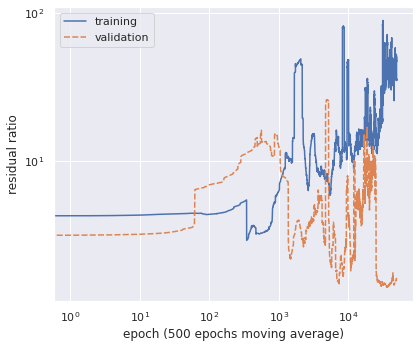

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./img', exist_ok=True)
sns.set()

data = pd.DataFrame(history)
data_avg = pd.DataFrame(moving_avg)

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=-data[['training_residual_ratio', 'validation_residual_ratio']],
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='residual ratio',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')
ax.hlines(y=0, xmin=0, xmax=EPOCHS, linestyles='dashed', colors='black')

plt.tight_layout()
plt.savefig('./img/ann_res_ratio.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=-data_avg[['training_residual_ratio', 'validation_residual_ratio']],
             ax=ax
            )
ax.set(title='',
       xlabel=f'epoch ({window:d} epochs moving average)',
       ylabel='residual ratio',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')
ax.hlines(y=0, xmin=0, xmax=EPOCHS, linestyles='dashed', colors='black')

plt.tight_layout()
plt.savefig('./img/ann_res_lumps_ratio.pdf', dpi=150, format='pdf')

In [43]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = 'ann_lumps'

# compute predictions
predictions = {'training':   list(model.predict(X_train_nn[:,2:-1]).reshape(-1,).astype(np.float64)),
               'validation': list(model.predict(X_val_nn[:,2:-1]).reshape(-1,).astype(np.float64)),
               'test':       list(model.predict(X_test_nn[:,2:-1]).reshape(-1,).astype(np.float64))
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training':   list(y_train_nn.numpy().reshape(-1,) - np.array(predictions['training'])),
               'validation': list(y_val_nn.numpy().reshape(-1,) - np.array(predictions['validation'])),
               'test':       list(y_test_nn.numpy().reshape(-1,) - np.array(predictions['test']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error':  [mse(y_train_nn.numpy().reshape(-1,), predictions['training']),
                                   mse(y_val_nn.numpy().reshape(-1,), predictions['validation']),
                                   mse(y_test_nn.numpy().reshape(-1,), predictions['test'])
                                  ],
           'mean_absolute_error': [mae(y_train_nn.numpy().reshape(-1,), predictions['training']),
                                   mae(y_val_nn.numpy().reshape(-1,), predictions['validation']),
                                   mae(y_test_nn.numpy().reshape(-1,), predictions['test'])
                                  ],
           'r2_score':            [r2(y_train_nn.numpy().reshape(-1,), predictions['training']),
                                   r2(y_val_nn.numpy().reshape(-1,), predictions['validation']),
                                   r2(y_test_nn.numpy().reshape(-1,), predictions['test'])
                                  ],
           'res_ratio':           [metric(y_train_nn.numpy().reshape(-1,), predictions['training'], X_train_nn[:,-1].numpy().reshape(-1,)),
                                   metric(y_val_nn.numpy().reshape(-1,), predictions['validation'], X_val_nn[:,-1].numpy().reshape(-1,)),
                                   metric(y_test_nn.numpy().reshape(-1,), predictions['test'], X_test_nn[:,-1].numpy().reshape(-1,))
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error,mean_absolute_error,r2_score,res_ratio
training,0.010046,0.041003,0.976643,-5.499754
validation,0.019783,0.052683,0.966476,-471.671342
test,0.033107,0.076931,0.931854,-2.537894


We finally plot the residuals:

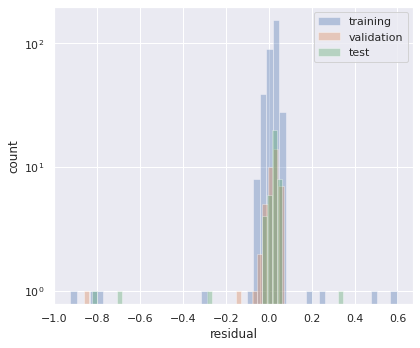

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = 'ann_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_hist.pdf', dpi=150, format='pdf')

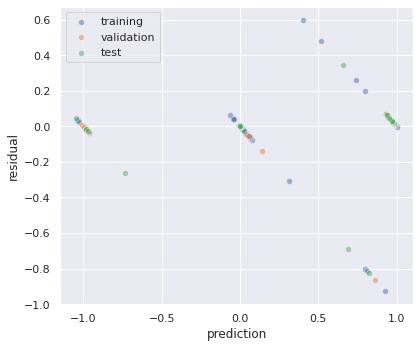

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = 'ann_lumps'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training'],
                y=residuals['training'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation'],
                y=residuals['validation'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test'],
                y=residuals['test'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction',
       ylabel='residual'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_res.pdf', dpi=150, format='pdf')

## WZW Model

We then focus on the WZW model and proceed in the same way for training the algorithms.
In general we try to predict both real and imaginary parts of the extrapolated labels at the same time.

In [46]:
import pandas as pd

wzw = pd.read_csv('./data/wzw.csv')

In [47]:
import numpy as np

def metric(y_true, y_pred, finite_res_re, finite_res_im):
    '''
    Measure the ratio between finite level truncation and the predictions.
    
    Arguments:
    
        y_true:        the true values,
        y_pred:        the predicted values,
        finite_res_re: the finite level truncation residues (real part),
        finite_res_im: the finite level truncation residues (imaginary part).
        
    Returns:
    
        the average ratio of the residuals.
    '''
    if type(y_true) is list:
        y_true = np.array(y_true)
    if type(y_pred) is list:
        y_pred = np.array(y_pred)
    if type(finite_res_re) is list:
        finite_res_re = np.array(finite_res_re)
    if type(finite_res_im) is list:
        finite_res_im = np.array(finite_res_im)
        
    finite_res = np.c_[finite_res_re, finite_res_im]        
    pred_res   = y_true - y_pred
    ratio      = np.abs(finite_res / pred_res)
    
    return -np.mean(np.mean(ratio, axis=0), axis=0)

We then add a column containing the difference between the last truncation level and the extrapolated label (i.e. the *residual* of the finite level truncation).
We then keep only a selected amount of data for the analysis, namely entries whose finite residue is less than $1$.

In [48]:
import numpy as np

finite_res_re     = np.abs(wzw['level_10_re'] - wzw['exp_re'])
finite_res_im     = np.abs(wzw['level_10_im'] - wzw['exp_im'])
wzw['finite_res_re'] = finite_res_re
wzw['finite_res_im'] = finite_res_im

# keep only samples whit finite residue less than the unit
wzw = wzw.loc[(wzw['finite_res_re'] < 1.0) & (wzw['finite_res_im'] < 1.0)]
wzw.describe()

,k,exp_re,weight,j,m,type,level_2_re,level_3_re,level_4_re,level_5_re,...,level_3_im,level_4_im,level_5_im,level_6_im,level_7_im,level_8_im,level_9_im,level_10_im,finite_res_re,finite_res_im
count,1483.000000,1483.000000,1483.00000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,...,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,6.774781,0.035420,0.83651,1.863790,0.000000,3.875927,-0.024849,-0.025209,0.061020,0.051667,...,-0.010657,-0.001865,0.001652,-0.004533,-0.006253,-0.001149,0.000285,-0.003767,0.133155,0.035730
std,1.309875,0.591421,0.57247,1.233388,1.629684,0.482606,1.103933,1.145377,0.715123,0.702623,...,0.377380,0.355100,0.303989,0.304008,0.317857,0.322291,0.316024,0.309860,0.227997,0.105363
min,2.000000,-1.519671,0.00000,0.000000,-4.000000,2.000000,-15.126171,-15.126171,-3.751433,-3.751433,...,-1.969113,-1.930349,-1.325220,-1.317791,-1.118745,-1.174883,-1.523793,-1.144340,0.000000,0.000000
25%,6.000000,-0.437426,0.37500,1.000000,-1.000000,4.000000,-0.520812,-0.540213,-0.451558,-0.426386,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006605,0.000000
50%,7.000000,0.000000,0.87500,2.000000,0.000000,4.000000,0.000504,0.004674,0.014272,0.012864,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027769,0.000000
75%,8.000000,0.500000,1.20000,3.000000,1.000000,4.000000,0.558110,0.575534,0.565181,0.554231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128556,0.022627
max,8.000000,1.414214,2.00000,4.000000,4.000000,4.000000,11.110720,11.110720,2.905008,2.905008,...,1.736677,1.930349,1.325220,1.161005,1.118745,1.174883,1.523793,1.144340,0.989321,0.924365


We then divide features and labels.

In [49]:
# divide features and labels
X  = wzw.drop(columns=['exp_re', 'exp_im'])
y  = wzw[['exp_re', 'exp_im']]

In general we will keep 80% of the data for training, 10% for validation and 10% for testing purposes:

In [50]:
from sklearn.model_selection import train_test_split

RAND = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=RAND)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=RAND)

In [51]:
X_train.to_csv('./data/X_train_wzw.csv', index=False)
X_val.to_csv('./data/X_val_wzw.csv', index=False)
X_test.to_csv('./data/X_test_wzw.csv', index=False)

y_train.to_csv('./data/y_train_wzw.csv', index=False)
y_val.to_csv('./data/y_val_wzw.csv', index=False)
y_test.to_csv('./data/y_test_wzw.csv', index=False)

### Linear Regression

We first use a simple linear regression with $\ell_2$ regularisation as a baseline computation.

In [52]:
from sklearn.linear_model import Ridge
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Real(1.0e-4, 1.0e2, prior='log-uniform', name='alpha'),
                 Integer(0, 1, name='fit_intercept'),
                 Integer(0, 1, name='normalize')
                ]
estimator = Ridge(random_state=RAND)

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))
    
    # return the metric
    return metric(y_val.values,
                  y_val_pred,
                  X_val['finite_res_re'].values,
                  X_val['finite_res_im'].values
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: Th

Optimisation took 539.692 seconds


In [53]:
# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip(names, results.x)), index=['values'])

,alpha,fit_intercept,normalize
values,0.132787,0,0


In [54]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_wzw'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/ridge_wzw.pkl']

In [55]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_wzw'

# compute predictions
predictions = {'training_re':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'validation_re': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'test_re':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'training_im':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'validation_im': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'test_im':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1])
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training_re':   list(y_train.values[:,0] - np.array(predictions['training_re'])),
               'validation_re': list(y_val.values[:,0] - np.array(predictions['validation_re'])),
               'test_re':       list(y_test.values[:,0] - np.array(predictions['test_re'])),
               'training_im':   list(y_train.values[:,1] - np.array(predictions['training_im'])),
               'validation_im': list(y_val.values[:,1] - np.array(predictions['validation_im'])),
               'test_im':       list(y_test.values[:,1] - np.array(predictions['test_im']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error_re':  [mse(y_train.values[:,0], predictions['training_re']),
                                      mse(y_val.values[:,0], predictions['validation_re']),
                                      mse(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_absolute_error_re': [mae(y_train.values[:,0], predictions['training_re']),
                                      mae(y_val.values[:,0], predictions['validation_re']),
                                      mae(y_test.values[:,0], predictions['test_re'])
                                     ],
           'r2_score_re':            [r2(y_train.values[:,0], predictions['training_re']),
                                      r2(y_val.values[:,0], predictions['validation_re']),
                                      r2(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_squared_error_im':  [mse(y_train.values[:,1], predictions['training_im']),
                                      mse(y_val.values[:,1], predictions['validation_im']),
                                      mse(y_test.values[:,1], predictions['test_im'])
                                     ],
           'mean_absolute_error_im': [mae(y_train.values[:,1], predictions['training_im']),
                                      mae(y_val.values[:,1], predictions['validation_im']),
                                      mae(y_test.values[:,1], predictions['test_im'])
                                     ],
           'r2_score_im':            [r2(y_train.values[:,1], predictions['training_im']),
                                      r2(y_val.values[:,1], predictions['validation_im']),
                                      r2(y_test.values[:,1], predictions['test_im'])
                                     ],
           'res_ratio':           [metric(y_train.values,
                                          np.c_[predictions['training_re'], predictions['training_im']],
                                          X_train['finite_res_re'].values.reshape(-1,),
                                          X_train['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_val.values,
                                          np.c_[predictions['validation_re'], predictions['validation_im']],
                                          X_val['finite_res_re'].values.reshape(-1,),
                                          X_val['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_test.values,
                                          np.c_[predictions['test_re'], predictions['test_im']],
                                          X_test['finite_res_re'].values.reshape(-1,),
                                          X_test['finite_res_im'].values.reshape(-1,)
                                         )
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error_re,mean_absolute_error_re,r2_score_re,mean_squared_error_im,mean_absolute_error_im,r2_score_im,res_ratio
training,0.004763,0.035312,0.986286,0.000286,0.006519,0.997052,-13.754769
validation,0.007327,0.042451,0.977397,0.000272,0.008293,0.997020,-16.237431
test,0.014443,0.040739,0.960577,0.000498,0.006629,0.993108,-8.895525


We finally plot the residuals:

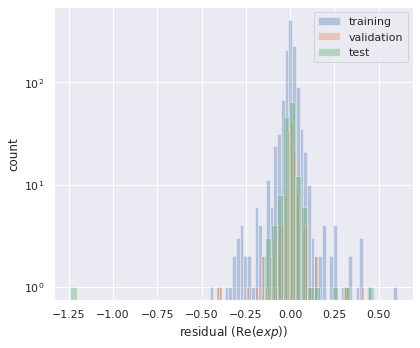

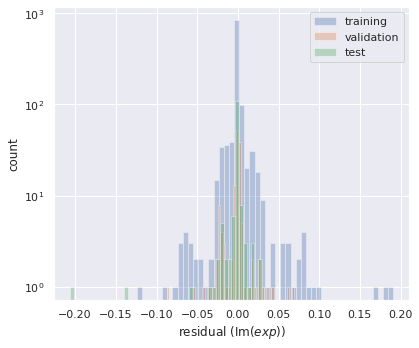

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_re'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_re'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_re'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Re}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_hist.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_im'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_im'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_im'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Im}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_hist.pdf', dpi=150, format='pdf')

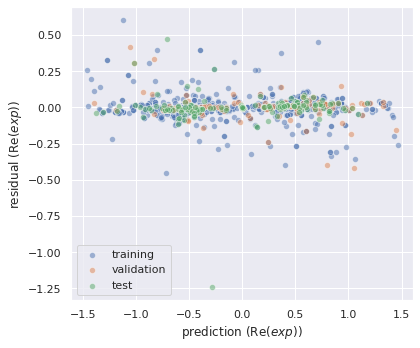

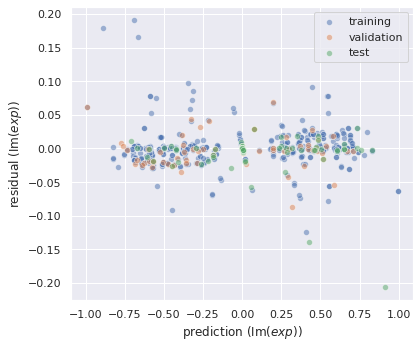

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = estimator.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_re'],
                y=residuals['training_re'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_re'],
                y=residuals['validation_re'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_re'],
                y=residuals['test_re'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Re}(exp)$)',
       ylabel='residual ($\mathrm{Re}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_res.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_im'],
                y=residuals['training_im'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_im'],
                y=residuals['validation_im'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_im'],
                y=residuals['test_im'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Im}(exp)$)',
       ylabel='residual ($\mathrm{Im}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_res.pdf', dpi=150, format='pdf')

### Support Vector Machines

We use the *kernel trick* (with a *radial basis function*) and SVM to produce the predictions.

In [58]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Real(1.0e-4, 1.0e1, prior='log-uniform', name='estimator__gamma'),
                 Real(1.0e-2, 1.0e2, prior='log-uniform', name='estimator__C'),
                 Real(1.0e-4, 1.0e-1, prior='log-uniform', name='estimator__epsilon')
                ]
inner_est = SVR(kernel='rbf')
estimator = MultiOutputRegressor(inner_est, n_jobs=-1)

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))
    
    # return the metric
    return metric(y_val.values,
                  y_val_pred,
                  X_val['finite_res_re'].values,
                  X_val['finite_res_im'].values
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

Optimisation took 632.767 seconds


In [59]:
import re

# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip([re.sub('estimator__', '', n) for n in names], results.x)), index=['values'])

,gamma,C,epsilon
values,0.313062,4.808919,0.0001


In [60]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/svr_wzw.pkl']

In [61]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'

# compute predictions
predictions = {'training_re':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'validation_re': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'test_re':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'training_im':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'validation_im': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'test_im':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1])
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training_re':   list(y_train.values[:,0] - np.array(predictions['training_re'])),
               'validation_re': list(y_val.values[:,0] - np.array(predictions['validation_re'])),
               'test_re':       list(y_test.values[:,0] - np.array(predictions['test_re'])),
               'training_im':   list(y_train.values[:,1] - np.array(predictions['training_im'])),
               'validation_im': list(y_val.values[:,1] - np.array(predictions['validation_im'])),
               'test_im':       list(y_test.values[:,1] - np.array(predictions['test_im']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error_re':  [mse(y_train.values[:,0], predictions['training_re']),
                                      mse(y_val.values[:,0], predictions['validation_re']),
                                      mse(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_absolute_error_re': [mae(y_train.values[:,0], predictions['training_re']),
                                      mae(y_val.values[:,0], predictions['validation_re']),
                                      mae(y_test.values[:,0], predictions['test_re'])
                                     ],
           'r2_score_re':            [r2(y_train.values[:,0], predictions['training_re']),
                                      r2(y_val.values[:,0], predictions['validation_re']),
                                      r2(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_squared_error_im':  [mse(y_train.values[:,1], predictions['training_im']),
                                      mse(y_val.values[:,1], predictions['validation_im']),
                                      mse(y_test.values[:,1], predictions['test_im'])
                                     ],
           'mean_absolute_error_im': [mae(y_train.values[:,1], predictions['training_im']),
                                      mae(y_val.values[:,1], predictions['validation_im']),
                                      mae(y_test.values[:,1], predictions['test_im'])
                                     ],
           'r2_score_im':            [r2(y_train.values[:,1], predictions['training_im']),
                                      r2(y_val.values[:,1], predictions['validation_im']),
                                      r2(y_test.values[:,1], predictions['test_im'])
                                     ],
           'res_ratio':           [metric(y_train.values,
                                          np.c_[predictions['training_re'], predictions['training_im']],
                                          X_train['finite_res_re'].values.reshape(-1,),
                                          X_train['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_val.values,
                                          np.c_[predictions['validation_re'], predictions['validation_im']],
                                          X_val['finite_res_re'].values.reshape(-1,),
                                          X_val['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_test.values,
                                          np.c_[predictions['test_re'], predictions['test_im']],
                                          X_test['finite_res_re'].values.reshape(-1,),
                                          X_test['finite_res_im'].values.reshape(-1,)
                                         )
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error_re,mean_absolute_error_re,r2_score_re,mean_squared_error_im,mean_absolute_error_im,r2_score_im,res_ratio
training,0.000618,0.007323,0.998220,0.000013,0.000887,0.999866,-1111.066073
validation,0.006259,0.032880,0.980691,0.002111,0.012429,0.976902,-98.259024
test,0.020703,0.035844,0.943489,0.002244,0.009728,0.968956,-271.808650


We finally plot the residuals:

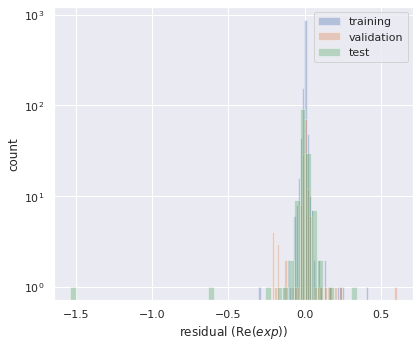

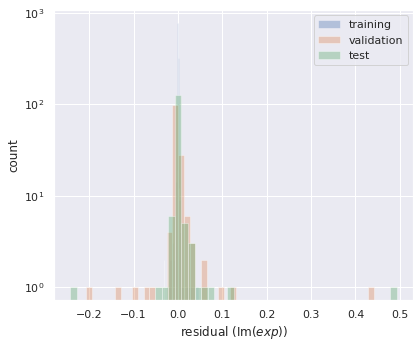

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_re'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_re'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_re'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Re}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_hist.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_im'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_im'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_im'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Im}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_hist.pdf', dpi=150, format='pdf')

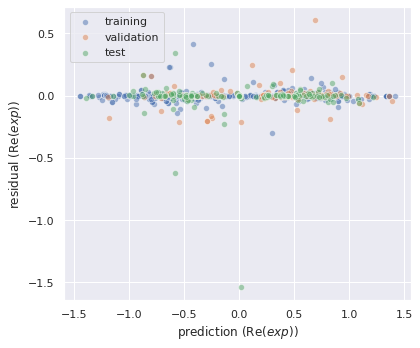

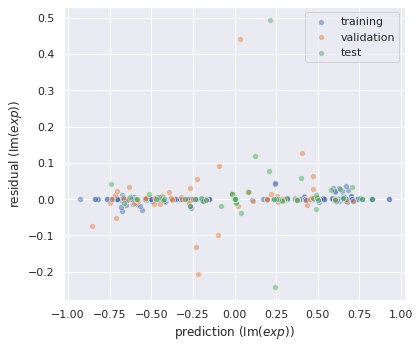

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_re'],
                y=residuals['training_re'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_re'],
                y=residuals['validation_re'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_re'],
                y=residuals['test_re'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Re}(exp)$)',
       ylabel='residual ($\mathrm{Re}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_res.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_im'],
                y=residuals['training_im'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_im'],
                y=residuals['validation_im'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_im'],
                y=residuals['test_im'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Im}(exp)$)',
       ylabel='residual ($\mathrm{Im}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_res.pdf', dpi=150, format='pdf')

### Gradient Boosted Decision Trees

We use gradient boosting to predict the extrapolated labels using decision trees.

In [64]:
from lightgbm import LGBMRegressor
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import time

search_spaces = [Integer(2, 25, name='estimator__num_leaves'),
                 Integer(2, 25, name='estimator__max_depth'),
                 Real(1e-3, 1e-1, prior='log-uniform', name='estimator__learning_rate'),
                 Integer(1e2, 1e4, prior='log-uniform', name='estimator__n_estimators'),
                 Real(0.8, 0.999, name='estimator__subsample'),
                 Real(0.7, 1.0, name='estimator__colsample_bytree'),
                 Real(1.0e-3, 1.0e-1, prior='log-uniform', name='estimator__min_child_weight'),
                 Real(1.0e0, 1.0e2, prior='log-uniform', name='estimator__reg_alpha'),
                 Real(1.0e0, 1.0e3, prior='log-uniform', name='estimator__reg_lambda')
                ]
inner_est = LGBMRegressor(boosting_type='gbdt',
                          objective='regression',
                          subsample_freq=1,
                          n_jobs=-1,
                          importance_type='gain'
                         )
estimator = MultiOutputRegressor(inner_est, n_jobs=-1)

@use_named_args(search_spaces)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    # fit the estimator
    estimator.set_params(**args)
    estimator.fit(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']),
                  y_train
                 )

    # compute predictions on the validation set
    y_val_pred = estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))
    
    # return the metric
    return metric(y_val.values,
                  y_val_pred,
                  X_val['finite_res_re'].values,
                  X_val['finite_res_im'].values
                 )

# fit the algorithm
optim_time = time.time()
results = gp_minimize(objective,
                      search_spaces,
                      n_calls=300,
                      random_state=RAND,
                      n_jobs=-1
                     )
optim_time = time.time() - optim_time
print(f'Optimisation took {optim_time:.3f} seconds')

Optimisation took 1109.333 seconds


In [65]:
import re

# print the parameters
names = [n.name for n in search_spaces]
pd.DataFrame(dict(zip([re.sub('estimator__', '', n) for n in names], results.x)), index=['values'])

,num_leaves,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda
values,17,9,0.001851,6131,0.989294,0.795848,0.004456,2.231591,273.923949


In [66]:
import joblib
import os

# set best parameters
estimator.set_params(**dict(zip(names, results.x)))

os.makedirs('./models', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
joblib.dump(estimator, f'./models/{name}.pkl')

['./models/lgbmregressor_wzw.pkl']

In [67]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'

# compute predictions
predictions = {'training_re':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'validation_re': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'test_re':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,0]),
               'training_im':   list(estimator.predict(X_train.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'validation_im': list(estimator.predict(X_val.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1]),
               'test_im':       list(estimator.predict(X_test.drop(columns=['k', 'j', 'm', 'finite_res_re', 'finite_res_im']))[:,1])
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training_re':   list(y_train.values[:,0] - np.array(predictions['training_re'])),
               'validation_re': list(y_val.values[:,0] - np.array(predictions['validation_re'])),
               'test_re':       list(y_test.values[:,0] - np.array(predictions['test_re'])),
               'training_im':   list(y_train.values[:,1] - np.array(predictions['training_im'])),
               'validation_im': list(y_val.values[:,1] - np.array(predictions['validation_im'])),
               'test_im':       list(y_test.values[:,1] - np.array(predictions['test_im']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error_re':  [mse(y_train.values[:,0], predictions['training_re']),
                                      mse(y_val.values[:,0], predictions['validation_re']),
                                      mse(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_absolute_error_re': [mae(y_train.values[:,0], predictions['training_re']),
                                      mae(y_val.values[:,0], predictions['validation_re']),
                                      mae(y_test.values[:,0], predictions['test_re'])
                                     ],
           'r2_score_re':            [r2(y_train.values[:,0], predictions['training_re']),
                                      r2(y_val.values[:,0], predictions['validation_re']),
                                      r2(y_test.values[:,0], predictions['test_re'])
                                     ],
           'mean_squared_error_im':  [mse(y_train.values[:,1], predictions['training_im']),
                                      mse(y_val.values[:,1], predictions['validation_im']),
                                      mse(y_test.values[:,1], predictions['test_im'])
                                     ],
           'mean_absolute_error_im': [mae(y_train.values[:,1], predictions['training_im']),
                                      mae(y_val.values[:,1], predictions['validation_im']),
                                      mae(y_test.values[:,1], predictions['test_im'])
                                     ],
           'r2_score_im':            [r2(y_train.values[:,1], predictions['training_im']),
                                      r2(y_val.values[:,1], predictions['validation_im']),
                                      r2(y_test.values[:,1], predictions['test_im'])
                                     ],
           'res_ratio':           [metric(y_train.values,
                                          np.c_[predictions['training_re'], predictions['training_im']],
                                          X_train['finite_res_re'].values.reshape(-1,),
                                          X_train['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_val.values,
                                          np.c_[predictions['validation_re'], predictions['validation_im']],
                                          X_val['finite_res_re'].values.reshape(-1,),
                                          X_val['finite_res_im'].values.reshape(-1,)
                                         ),
                                   metric(y_test.values,
                                          np.c_[predictions['test_re'], predictions['test_im']],
                                          X_test['finite_res_re'].values.reshape(-1,),
                                          X_test['finite_res_im'].values.reshape(-1,)
                                         )
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error_re,mean_absolute_error_re,r2_score_re,mean_squared_error_im,mean_absolute_error_im,r2_score_im,res_ratio
training,0.060958,0.191192,0.824502,0.015955,0.069860,0.835537,-1.029705
validation,0.067790,0.204241,0.790874,0.016497,0.070867,0.819526,-0.824957
test,0.062816,0.201915,0.828538,0.012664,0.056080,0.824834,-0.720740


We finally plot the residuals:

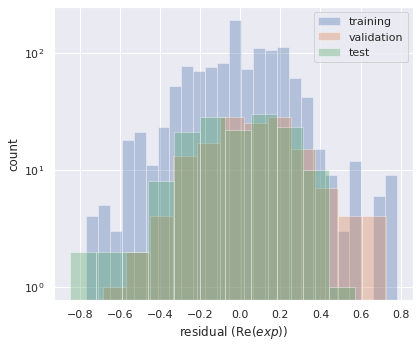

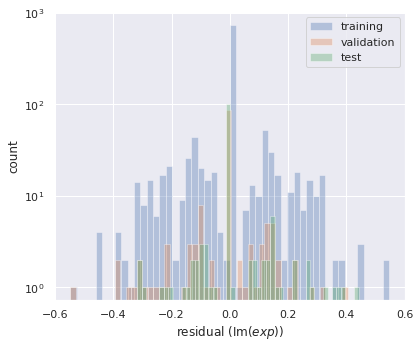

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_re'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_re'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_re'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Re}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_hist.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_im'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_im'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_im'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Im}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_hist.pdf', dpi=150, format='pdf')

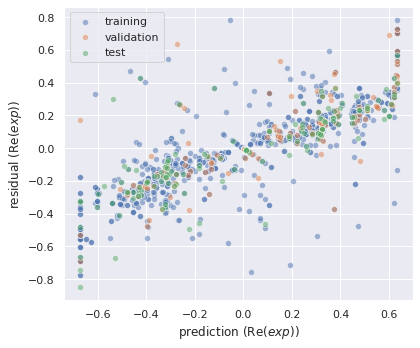

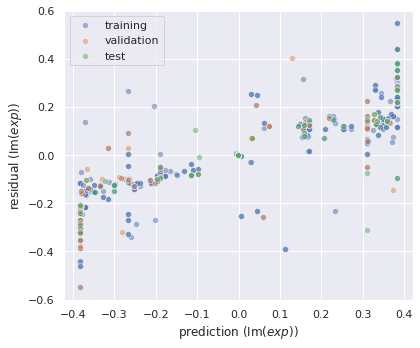

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = inner_est.__class__.__name__.lower() + '_wzw'
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_re'],
                y=residuals['training_re'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_re'],
                y=residuals['validation_re'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_re'],
                y=residuals['test_re'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Re}(exp)$)',
       ylabel='residual ($\mathrm{Re}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_res.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_im'],
                y=residuals['training_im'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_im'],
                y=residuals['validation_im'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_im'],
                y=residuals['test_im'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Im}(exp)$)',
       ylabel='residual ($\mathrm{Im}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_res.pdf', dpi=150, format='pdf')

### Neural Networks

We finally use a fully connected ANN built using Keras.

In [70]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Convert everything to tensor and build the model.

In [71]:
import os
os.makedirs('./models', exist_ok=True)

In [72]:
X_train_nn = tf.convert_to_tensor(X_train.drop(columns=['k', 'j', 'm']), dtype=tf.float32)
X_val_nn   = tf.convert_to_tensor(X_val.drop(columns=['k', 'j', 'm']), dtype=tf.float32)
X_test_nn  = tf.convert_to_tensor(X_test.drop(columns=['k', 'j', 'm']), dtype=tf.float32)

y_train_nn = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_nn   = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test_nn  = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [73]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

# reset graph
tf.keras.backend.clear_session()
tf.random.set_seed(RAND)

# define the input shape
input_shape = X_train_nn[:,0:-2].shape[1:]

# build the model
I = Input(shape=input_shape)
x = I

x = Dense(50, activation='relu')(x)
x = Dropout(rate=0.01)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(rate=0.01)(x)
x = Dense(20, activation='relu')(x)
x = Dense(10, activation='relu')(x)

# output layers
exp_re = Dense(1, name='exp_re')(x)
exp_im = Dense(1, name='exp_im')(x)

# create the model
model = Model(inputs=I, outputs=[exp_re, exp_im], name='wzw_model')

In [74]:
import json
import os

os.makedirs('./models', exist_ok=True)
with open('./models/ann_wzw.json', 'w') as ann:
    json.dump(model.to_json(), ann)

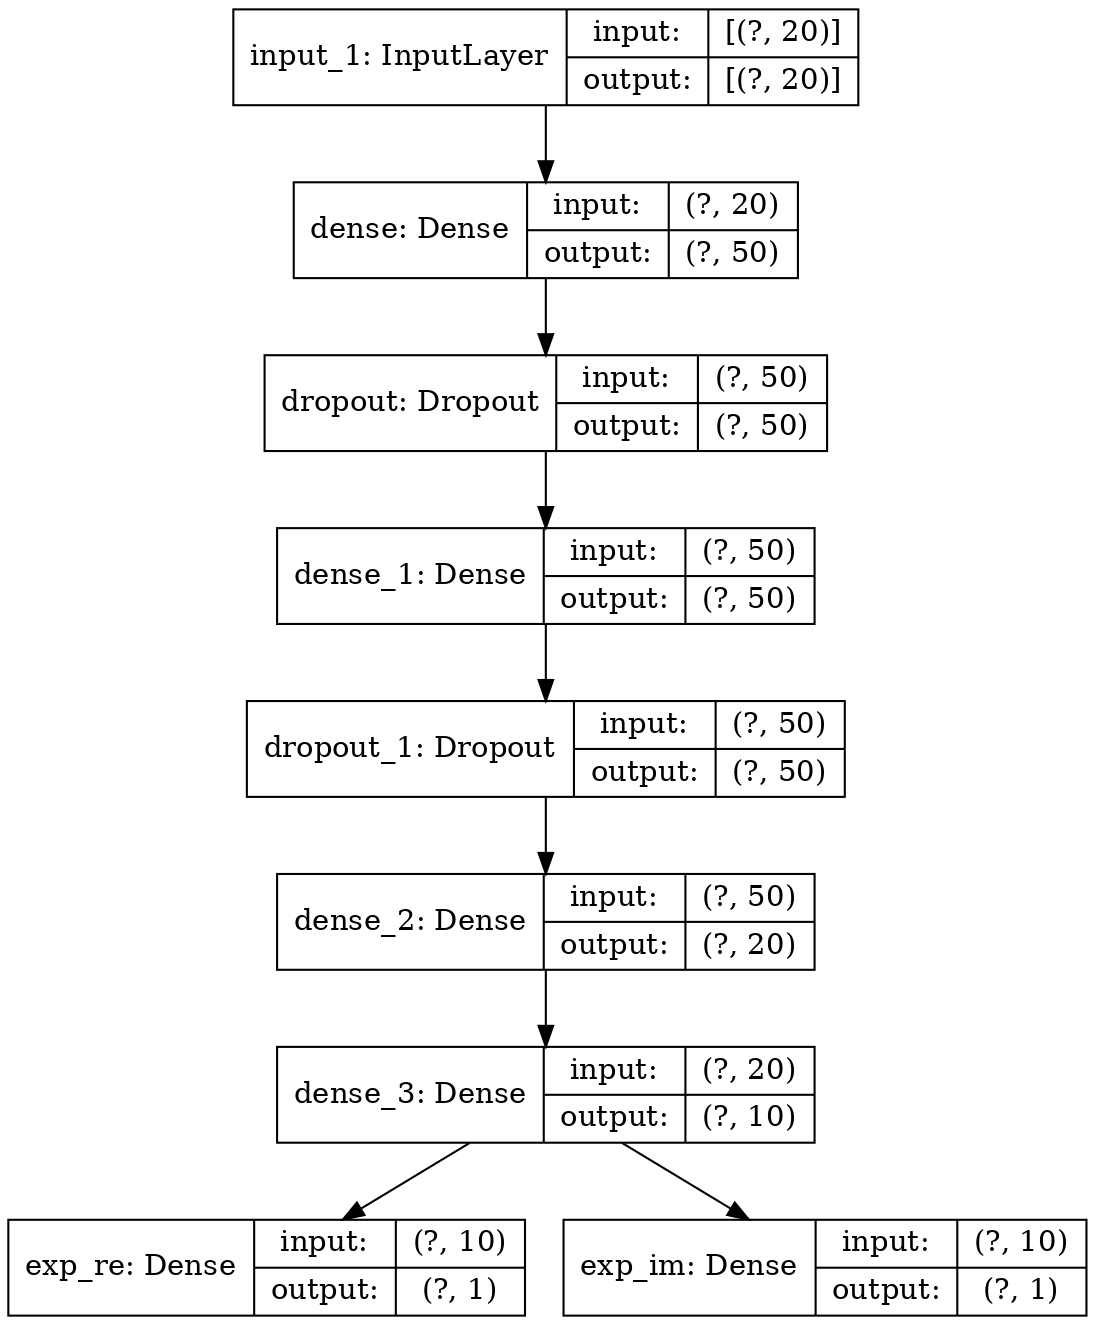

In [75]:
import os
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

os.makedirs('./img', exist_ok=True)
model_dot = model_to_dot(model, show_shapes=True, dpi=150)
model_dot.write_pdf('./img/ann_lumps_arch.pdf')

Image(model_dot.create_png(), width=320)

We then prepare the dataset objects:

In [76]:
import tensorflow as tf

BATCH_SIZE = 32
train = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn)).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
val   = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn)).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
test  = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_nn))

We then proceed with the definition of the loss function in terms of *Tensorflow* tensors:

In [77]:
import tensorflow as tf

def ratio_loss(y_true, y_pred, fin_res_re, fin_res_im):
    '''
    Compute the loss using tensors.
    
    Arguments:
    
        y_true:     true values,
        y_pred:     predicted values,
        fin_res_re: values of the residuals of the finite truncation levels (real parts),
        fin_res_im: values of the residuals of the finite truncation levels (imaginary parts).
    '''
    
    pred_res_re = tf.math.subtract(y_true[:,0], y_pred[0][:,0])
    ratio_re    = tf.math.abs(tf.math.divide(fin_res_re, pred_res_re))
    ratio_re    = tf.math.reduce_mean(ratio_re)
    pred_res_im = tf.math.subtract(y_true[:,1], y_pred[1][:,0])
    ratio_im    = tf.math.abs(tf.math.divide(fin_res_im, pred_res_im))
    ratio_im    = tf.math.reduce_mean(ratio_im)
    
    return -0.75 * ratio_re - 0.25 * ratio_im

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-4)

We then use the **mean squared error** for backpropagating and updating the weights.
We however evaluate the netowrk on the residual ratio.

In [79]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        y_pred = model(x[:,0:-2], training=True)
        res    = ratio_loss(y, y_pred, x[:,-2], x[:,-1])
        mse    = tf.keras.losses.MeanSquaredError()(y, y_pred, sample_weight=[0.75, 0.25])
        mae    = tf.keras.losses.MeanAbsoluteError()(y, y_pred, sample_weight=[0.75, 0.25])
        
    grad = tape.gradient(mse, model.trainable_weights)
    #grad = [(tf.clip_by_value(g, -1.0e6, 1.0e6)) for g in grad]
    optimizer.apply_gradients(zip(grad, model.trainable_weights))
        
    return {'residual_ratio': res,
            'mean_squared_error': mse,
            'mean_absolute_error': mae
           }

In [80]:
@tf.function
def test_step(x, y):
    
    with tf.GradientTape() as tape:
        y_pred = model(x[:,0:-2], training=False)
        res    = ratio_loss(y, y_pred, x[:,-2], x[:,-1])
        mse    = tf.keras.losses.MeanSquaredError()(y, y_pred, sample_weight=[0.75, 0.25])
        mae    = tf.keras.losses.MeanAbsoluteError()(y, y_pred, sample_weight=[0.75, 0.25])
        
    return {'residual_ratio': res,
            'mean_squared_error': mse,
            'mean_absolute_error': mae
           }

We finally train the model:

In [81]:
EPOCHS = 50000

In [82]:
from tqdm import trange
import numpy as np

def train_loop(dataset):
    
    # store metrics and losses
    metrics = {'training_residual_ratio':   [],
               'validation_residual_ratio': [],
               'training_mse': [],
               'validation_mse': [],
               'training_mae': [],
               'validation_mae': []
              }
    
    best_val_loss = np.inf
    
    with trange(EPOCHS, desc='Training epochs', unit='epochs') as pbar:
        
        for epoch in pbar:
            
            # save metrics for each batch
            train_res_epoch = []
            val_res_epoch   = []
            
            train_mse_epoch  = []
            val_mse_epoch    = []
            
            train_mae_epoch  = []
            val_mae_epoch    = []
            
            for (x, y) in train:
                train_metrics = train_step(x, y)
                train_res_epoch.append(train_metrics['residual_ratio'])
                train_mse_epoch.append(train_metrics['mean_squared_error'])
                train_mae_epoch.append(train_metrics['mean_absolute_error'])
            for (x, y) in val:
                val_metrics = test_step(x, y)
                val_res_epoch.append(val_metrics['residual_ratio'])
                val_mse_epoch.append(val_metrics['mean_squared_error'])
                val_mae_epoch.append(val_metrics['mean_absolute_error'])
            
            # update the bar
            epoch_metrics = {'res': float(tf.math.reduce_mean(train_res_epoch)),
                             'mse': float(tf.math.reduce_mean(train_mse_epoch)),
                             'mae': float(tf.math.reduce_mean(train_mae_epoch)),
                             'val_res': float(tf.math.reduce_mean(val_res_epoch)),
                             'val_mse': float(tf.math.reduce_mean(val_mse_epoch)),
                             'val_mae': float(tf.math.reduce_mean(val_mae_epoch))
                            }
            pbar.set_postfix(epoch_metrics)
            
            # save best model
            if epoch_metrics['val_res'] < best_val_loss:
                best_val_loss = epoch_metrics['val_res']
                model.save_weights('./models/ann_wzw.h5')
                
            # add metrics for each epoch
            metrics['training_residual_ratio'].append(epoch_metrics['res'])
            metrics['training_mse'].append(epoch_metrics['mse'])
            metrics['training_mae'].append(epoch_metrics['mae'])
            metrics['validation_residual_ratio'].append(epoch_metrics['val_res'])
            metrics['validation_mse'].append(epoch_metrics['val_mse'])
            metrics['validation_mae'].append(epoch_metrics['val_mae'])
            
    return metrics

In [83]:
history = train_loop(train)
model.load_weights('./models/ann_wzw.h5')

Training epochs: 100%|██████████| 50000/50000 [42:24<00:00, 19.65epochs/s, res=-9.75, mse=0.0546, mae=0.142, val_res=-7.79, val_mse=0.0556, val_mae=0.144]   


In [84]:
import json
import os

os.makedirs('./predictions', exist_ok=True)
with open('./predictions/ann_history.json', 'w') as hist:
    json.dump(history, hist)

We can finally show the loss function:

In [85]:
window = int(0.01 * EPOCHS)
moving_avg = {k: np.convolve(v, np.ones((window,)) / window, mode='valid') for k, v in history.items()}

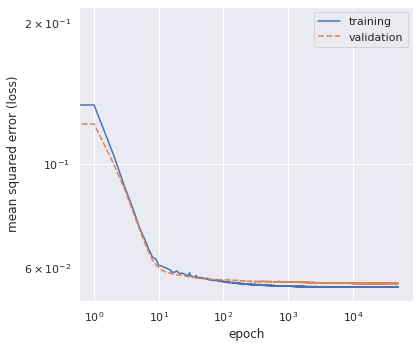

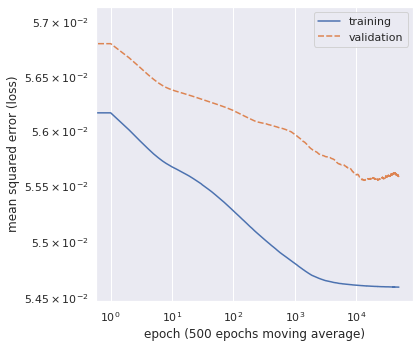

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./img', exist_ok=True)
sns.set()

data = pd.DataFrame(history)
data_avg = pd.DataFrame(moving_avg)

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data[['training_mse', 'validation_mse']],
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='mean squared error (loss)',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')

plt.tight_layout()
plt.savefig('./img/ann_loss.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data_avg[['training_mse', 'validation_mse']],
             ax=ax
            )
ax.set(title='',
       xlabel=f'epoch ({window:d} epochs moving average)',
       ylabel='mean squared error (loss)',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')

plt.tight_layout()
plt.savefig('./img/ann_loss_wzw_avg.pdf', dpi=150, format='pdf')

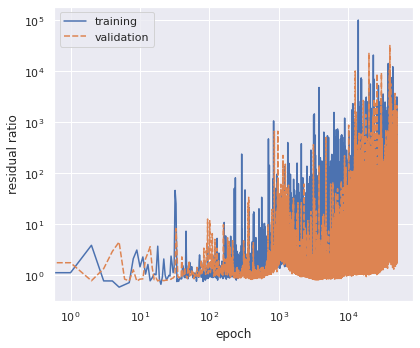

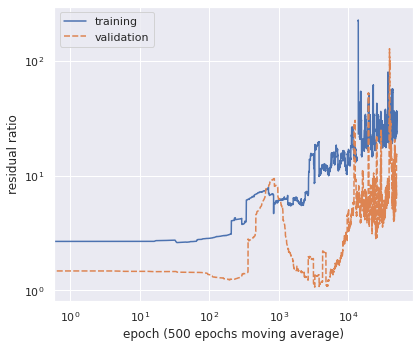

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./img', exist_ok=True)
sns.set()

data = pd.DataFrame(history)
data_avg = pd.DataFrame(moving_avg)

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=-data[['training_residual_ratio', 'validation_residual_ratio']],
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='residual ratio',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')
ax.hlines(y=0, xmin=0, xmax=EPOCHS, linestyles='dashed', colors='black')

plt.tight_layout()
plt.savefig('./img/ann_res_ratio.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=-data_avg[['training_residual_ratio', 'validation_residual_ratio']],
             ax=ax
            )
ax.set(title='',
       xlabel=f'epoch ({window:d} epochs moving average)',
       ylabel='residual ratio',
       xscale='log',
       yscale='log'
      )
ax.legend(['training', 'validation'], loc='best')
ax.hlines(y=0, xmin=0, xmax=EPOCHS, linestyles='dashed', colors='black')

plt.tight_layout()
plt.savefig('./img/ann_res_wzw_ratio.pdf', dpi=150, format='pdf')

In [88]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import os
import json

os.makedirs('./predictions', exist_ok=True)
name = 'ann_wzw'

# compute predictions
predictions = {'training_re':   list(model.predict(X_train_nn[:,0:-2])[0][:,0].astype(np.float64)),
               'validation_re': list(model.predict(X_val_nn[:,0:-2])[0][:,0].astype(np.float64)),
               'test_re':       list(model.predict(X_test_nn[:,0:-2])[0][:,0].astype(np.float64)),
               'training_im':   list(model.predict(X_train_nn[:,0:-2])[1][:,0].astype(np.float64)),
               'validation_im': list(model.predict(X_val_nn[:,0:-2])[1][:,0].astype(np.float64)),
               'test_im':       list(model.predict(X_test_nn[:,0:-2])[1][:,0].astype(np.float64))
              }
with open(f'./predictions/{name}_pred.json', 'w') as pred:
    json.dump(predictions, pred)

residuals   = {'training_re':   list(y_train_nn.numpy()[:,0].reshape(-1,) - np.array(predictions['training_re'])),
               'validation_re': list(y_val_nn.numpy()[:,0].reshape(-1,) - np.array(predictions['validation_re'])),
               'test_re':       list(y_test_nn.numpy()[:,0].reshape(-1,) - np.array(predictions['test_re'])),
               'training_im':   list(y_train_nn.numpy()[:,1].reshape(-1,) - np.array(predictions['training_im'])),
               'validation_im': list(y_val_nn.numpy()[:,1].reshape(-1,) - np.array(predictions['validation_im'])),
               'test_im':       list(y_test_nn.numpy()[:,1].reshape(-1,) - np.array(predictions['test_im']))
              }
with open(f'./predictions/{name}_res.json', 'w') as res:
    json.dump(residuals, res)

# print the metrics
metrics = {'mean_squared_error_re':  [mse(y_train_nn.numpy()[:,0].reshape(-1,), predictions['training_re']),
                                      mse(y_val_nn.numpy()[:,0].reshape(-1,), predictions['validation_re']),
                                      mse(y_test_nn.numpy()[:,0].reshape(-1,), predictions['test_re'])
                                     ],
           'mean_absolute_error_re': [mae(y_train_nn.numpy()[:,0].reshape(-1,), predictions['training_re']),
                                      mae(y_val_nn.numpy()[:,0].reshape(-1,), predictions['validation_re']),
                                      mae(y_test_nn.numpy()[:,0].reshape(-1,), predictions['test_re'])
                                     ],
           'r2_score_re':            [r2(y_train_nn.numpy()[:,0].reshape(-1,), predictions['training_re']),
                                      r2(y_val_nn.numpy()[:,0].reshape(-1,), predictions['validation_re']),
                                      r2(y_test_nn.numpy()[:,0].reshape(-1,), predictions['test_re'])
                                     ],
           'mean_squared_error_im':  [mse(y_train_nn.numpy()[:,1].reshape(-1,), predictions['training_im']),
                                      mse(y_val_nn.numpy()[:,1].reshape(-1,), predictions['validation_im']),
                                      mse(y_test_nn.numpy()[:,1].reshape(-1,), predictions['test_im'])
                                     ],
           'mean_absolute_error_im': [mae(y_train_nn.numpy()[:,1].reshape(-1,), predictions['training_im']),
                                      mae(y_val_nn.numpy()[:,1].reshape(-1,), predictions['validation_im']),
                                      mae(y_test_nn.numpy()[:,1].reshape(-1,), predictions['test_im'])
                                     ],
           'r2_score_im':            [r2(y_train_nn.numpy()[:,1].reshape(-1,), predictions['training_im']),
                                      r2(y_val_nn.numpy()[:,1].reshape(-1,), predictions['validation_im']),
                                      r2(y_test_nn.numpy()[:,1].reshape(-1,), predictions['test_im'])
                                     ],
           'res_ratio':           [metric(y_train_nn.numpy(),
                                          np.c_[predictions['training_re'], predictions['training_im']],
                                          X_train_nn[:,-2].numpy().reshape(-1,),
                                          X_train_nn[:,-1].numpy().reshape(-1,)
                                         ),
                                   metric(y_val_nn.numpy(),
                                          np.c_[predictions['validation_re'], predictions['validation_im']],
                                          X_val_nn[:,-2].numpy().reshape(-1,),
                                          X_val_nn[:,-1].numpy().reshape(-1,)
                                         ),
                                   metric(y_test_nn.numpy(),
                                          np.c_[predictions['test_re'], predictions['test_im']],
                                          X_test_nn[:,-2].numpy().reshape(-1,),
                                          X_test_nn[:,-1].numpy().reshape(-1,)
                                         )
                                  ]
          }
with open(f'./predictions/{name}_met.json', 'w') as met:
    json.dump(metrics, met)

pd.DataFrame(metrics, index=['training', 'validation', 'test'])

,mean_squared_error_re,mean_absolute_error_re,r2_score_re,mean_squared_error_im,mean_absolute_error_im,r2_score_im,res_ratio
training,0.114300,0.291198,0.670928,0.108815,0.284876,-0.121668,-7.491449
validation,0.114087,0.289242,0.648052,0.108536,0.285241,-0.187369,-27320.782456
test,0.114954,0.297355,0.686222,0.106462,0.286162,-0.472508,-6.000422


We finally plot the residuals:

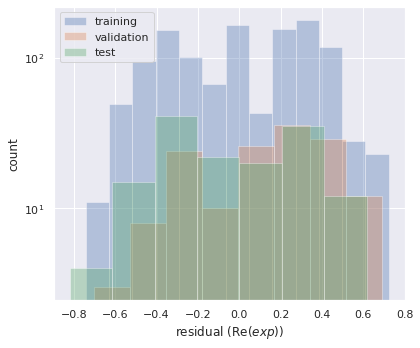

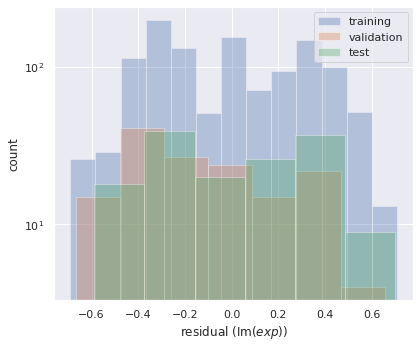

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = 'ann_wzw'
sns.set()
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_re'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_re'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_re'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Re}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_hist.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['training_im'],
             kde=False,
             label='training',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['validation_im'],
             kde=False,
             label='validation',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['test_im'],
             kde=False,
             label='test',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
ax.set(title='',
       xlabel='residual ($\mathrm{Im}(exp)$)',
       ylabel='count',
       yscale='log'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_hist.pdf', dpi=150, format='pdf')

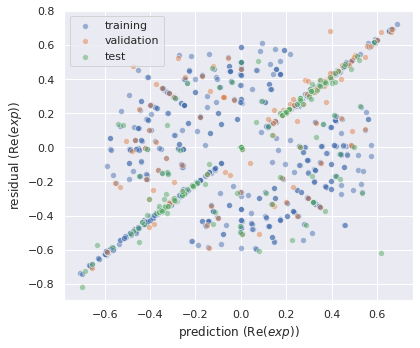

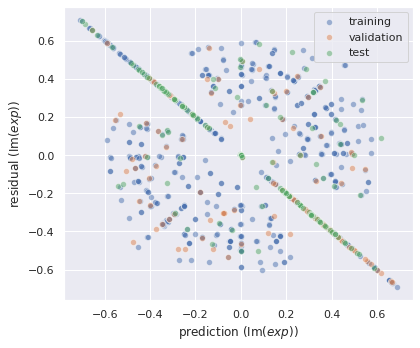

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
name = 'ann_wzw'
sns.set()
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_re'],
                y=residuals['training_re'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_re'],
                y=residuals['validation_re'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_re'],
                y=residuals['test_re'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Re}(exp)$)',
       ylabel='residual ($\mathrm{Re}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_re_res.pdf', dpi=150, format='pdf')

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=predictions['training_im'],
                y=residuals['training_im'],
                label='training',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['validation_im'],
                y=residuals['validation_im'],
                label='validation',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=predictions['test_im'],
                y=residuals['test_im'],
                label='test',
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='prediction ($\mathrm{Im}(exp)$)',
       ylabel='residual ($\mathrm{Im}(exp)$)'
      )
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f'./img/{name}_im_res.pdf', dpi=150, format='pdf')

## Double Lumps

In this section we use the algorithms trained for the **lump solutions** to make predictions on the double lumps since they should behave approximately in the same way.
Since the *double lumps* are approximately scaled by a factor 2 with respect to the lumps, we first divide their labels by 2 and the multiply afterwards.
We will provide the metrics for the subset containing only weights $h < 1.25$.

In [91]:
import pandas as pd

dlumps = pd.read_csv('./data/dlumps.csv')
dlumps = dlumps.loc[dlumps['weight'] < 1.25]
dlumps = dlumps.sample(frac=1, random_state=RAND)
X      = dlumps.drop(columns=['init', 'exp']).copy()
y      = dlumps['exp'].copy().values.reshape(-1,)

In [92]:
SCALING = 2.0

# rescale (in general it works also w/o scaling)
X /= SCALING
#y /= SCALING

In [93]:
import joblib
import tensorflow as tf

# load the models
ridge = joblib.load('./models/ridge_lumps.pkl')
svr   = joblib.load('./models/svr_lumps.pkl')
gbdt  = joblib.load('./models/lgbmregressor_lumps.pkl')
with open('./models/ann_lumps.json') as model:
    ann = tf.keras.models.model_from_json(json.load(model))
    ann.load_weights('./models/ann_lumps.h5')

In [94]:
# compute the predictions
dlumps['exp_ridge'] = SCALING * ridge.predict(X).reshape(-1,)
dlumps['exp_svr']   = SCALING * svr.predict(X).reshape(-1,)
#dlumps['exp_gbdt']  = SCALING * gbdt.predict(X).reshape(-1,)
dlumps['exp_ann']   = SCALING * ann.predict(X).reshape(-1,)

# save and show
dlumps.to_csv('./data/dlumps_predictions.csv', index=False)
dlumps

,init,weight,type,level_2,level_3,level_4,level_5,level_6,level_7,level_8,...,level_13,level_14,level_15,level_16,level_17,level_18,exp,exp_ridge,exp_svr,exp_ann
6,0,0.027778,4,0.623568,0.629606,0.679687,0.728737,0.740993,0.780145,0.788949,...,0.849563,0.854017,0.862205,0.865900,0.871932,0.875055,0.955293,0.970636,1.009279,1.151665
0,3,0.000000,2,2.171332,2.095383,2.061599,2.049103,2.036695,2.032430,2.026098,...,2.015958,2.014117,2.013663,2.012277,2.011954,2.010872,2.000132,1.912903,1.960438,2.079174
9,0,0.444444,4,-0.260634,0.245390,0.018296,-0.065992,-0.163463,-0.278041,-0.275079,...,-0.470032,-0.508464,-0.530455,-0.530770,-0.547288,-0.573408,-0.827465,-0.784574,-0.630237,-0.619263
7,0,0.111111,4,-1.127603,-1.356035,-1.308665,-1.304701,-1.297414,-1.264143,-1.255992,...,-1.201632,-1.196022,-1.188145,-1.183296,-1.178235,-1.174038,-1.083093,-1.014940,-1.304657,-1.170583
10,0,0.694444,4,0.000000,2.499696,2.541947,1.322530,1.318475,1.825239,1.823133,...,1.446837,1.437245,1.507952,1.498861,1.417021,1.409107,1.213654,1.283338,1.527587,1.496989
5,3,0.000000,4,2.136349,2.065352,2.054196,2.042292,2.030414,2.026539,2.022864,...,2.013425,2.011081,2.010701,2.009857,2.009593,2.008174,1.998589,1.938590,2.002430,1.962977
1,0,0.000000,2,0.027517,0.008433,0.004265,0.003270,0.001883,0.001637,0.001011,...,0.000327,0.000198,0.000191,0.000103,0.000101,0.000039,-0.000045,0.020136,0.064091,0.054869
8,0,0.250000,4,-1.870796,-1.633202,-1.734322,-1.825242,-1.856547,-1.855997,-1.872730,...,-1.933232,-1.939385,-1.936520,-1.941151,-1.948500,-1.952275,-1.994476,-1.910406,-1.967150,-1.660808
11,0,1.000000,4,0.000000,0.000000,2.245192,2.527950,0.584574,0.592287,2.249617,...,2.187400,1.429024,1.433263,2.086919,2.103089,1.585226,2.015004,2.048013,1.922811,1.824125
2,3,1.000000,4,-1.836644,-2.650099,-1.410749,-1.396058,-2.122534,-2.166743,-1.737768,...,-1.823713,-2.064218,-2.068392,-1.878755,-1.873888,-2.048203,-2.000161,-1.950378,-1.944731,-1.753145


In [95]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import pandas as pd

# compute the metrics
metrics = {'mean_squared_error': [mse(y, dlumps[f]) for f in ['exp_ridge',
                                                              'exp_svr',
                                                              #'exp_gbdt',
                                                              'exp_ann'
                                                             ]
                                 ],
           'mean_absolute_error': [mae(y, dlumps[f]) for f in ['exp_ridge',
                                                               'exp_svr',
                                                               #'exp_gbdt',
                                                               'exp_ann'
                                                              ]
                                  ],
           'r2_score': [r2(y, dlumps[f]) for f in ['exp_ridge',
                                                   'exp_svr',
                                                   #'exp_gbdt',
                                                   'exp_ann'
                                                  ]
                      ],
          }

metrics = pd.DataFrame(metrics, index=['ridge',
                                       'svr',
                                       #'gbdt',
                                       'ann'
                                      ]
                      )
metrics

,mean_squared_error,mean_absolute_error,r2_score
ridge,0.003383,0.053034,0.998576
svr,0.020748,0.106933,0.991267
ann,0.038916,0.171653,0.983620


In [96]:
# compute the residuals
residuals = {k: y - dlumps['exp_' + k] for k in ['ridge',
                                                 'svr',
                                                 #'gbdt',
                                                 'ann'
                                                ]
            }

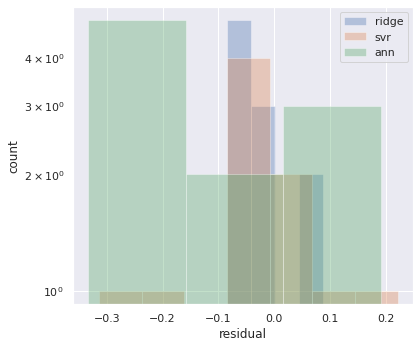

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(residuals['ridge'],
             kde=False,
             label='ridge',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
sns.distplot(residuals['svr'],
             kde=False,
             label='svr',
             hist_kws={'alpha': 0.35},
             ax=ax
            )
#sns.distplot(residuals['gbdt'],
#             kde=False,
#             label='gbdt',
#             hist_kws={'alpha': 0.35},
#             ax=ax
#            )
sns.distplot(residuals['ann'],
             kde=False,
             label='ann',
             hist_kws={'alpha': 0.35},
             ax=ax
            )

ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )
ax.legend(['ridge',
           'svr',
           #'gbdt',
           'ann'
          ],
          loc='best'
         )

plt.tight_layout()
plt.savefig('./img/dlumps_hist.pdf', dpi=150, format='pdf')

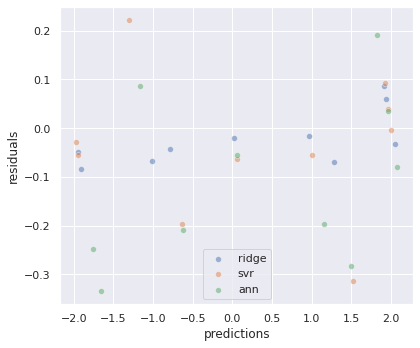

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=dlumps['exp_ridge'],
                y=residuals['ridge'],
                label='ridge',
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=dlumps['exp_svr'],
                y=residuals['svr'],
                label='svr',
                alpha=0.5,
                ax=ax
               )
#sns.scatterplot(x=dlumps['exp_gbdt'],
#                y=residuals['gbdt'],
#                label='gbdt',
#                alpha=0.5,
#                ax=ax
#               )

sns.scatterplot(x=dlumps['exp_ann'],
                y=residuals['ann'],
                label='ann',
                alpha=0.5,
                ax=ax
               )

ax.set(title='',
       xlabel='predictions',
       ylabel='residuals',
      )
ax.legend(['ridge',
           'svr',
           #'gbdt',
           'ann'
          ],
          loc='best'
         )

plt.tight_layout()
plt.savefig('./img/dlumps_resplot.pdf', dpi=150, format='pdf')

### Stacking

We finally try to stack a linear regressor on top of the predictions of Ridge, SVR and ANN.

In [99]:
from sklearn.linear_model import LinearRegression

stack = LinearRegression(fit_intercept=False)
X_stack = dlumps[['exp_ridge', 'exp_svr', 'exp_ann']]
y_stack = dlumps['exp'].values.reshape(-1, 1)

# train the algorithm
stack.fit(X_stack, y_stack)

# compute predictions
dlumps['exp_stack'] = stack.predict(X_stack).reshape(-1,)

In [100]:
dlumps

,init,weight,type,level_2,level_3,level_4,level_5,level_6,level_7,level_8,...,level_14,level_15,level_16,level_17,level_18,exp,exp_ridge,exp_svr,exp_ann,exp_stack
6,0,0.027778,4,0.623568,0.629606,0.679687,0.728737,0.740993,0.780145,0.788949,...,0.854017,0.862205,0.865900,0.871932,0.875055,0.955293,0.970636,1.009279,1.151665,0.974615
0,3,0.000000,2,2.171332,2.095383,2.061599,2.049103,2.036695,2.032430,2.026098,...,2.014117,2.013663,2.012277,2.011954,2.010872,2.000132,1.912903,1.960438,2.079174,1.934491
9,0,0.444444,4,-0.260634,0.245390,0.018296,-0.065992,-0.163463,-0.278041,-0.275079,...,-0.508464,-0.530455,-0.530770,-0.547288,-0.573408,-0.827465,-0.784574,-0.630237,-0.619263,-0.800013
7,0,0.111111,4,-1.127603,-1.356035,-1.308665,-1.304701,-1.297414,-1.264143,-1.255992,...,-1.196022,-1.188145,-1.183296,-1.178235,-1.174038,-1.083093,-1.014940,-1.304657,-1.170583,-1.040351
10,0,0.694444,4,0.000000,2.499696,2.541947,1.322530,1.318475,1.825239,1.823133,...,1.437245,1.507952,1.498861,1.417021,1.409107,1.213654,1.283338,1.527587,1.496989,1.305031
5,3,0.000000,4,2.136349,2.065352,2.054196,2.042292,2.030414,2.026539,2.022864,...,2.011081,2.010701,2.009857,2.009593,2.008174,1.998589,1.938590,2.002430,1.962977,1.973630
1,0,0.000000,2,0.027517,0.008433,0.004265,0.003270,0.001883,0.001637,0.001011,...,0.000198,0.000191,0.000103,0.000101,0.000039,-0.000045,0.020136,0.064091,0.054869,0.020832
8,0,0.250000,4,-1.870796,-1.633202,-1.734322,-1.825242,-1.856547,-1.855997,-1.872730,...,-1.939385,-1.936520,-1.941151,-1.948500,-1.952275,-1.994476,-1.910406,-1.967150,-1.660808,-1.967269
11,0,1.000000,4,0.000000,0.000000,2.245192,2.527950,0.584574,0.592287,2.249617,...,1.429024,1.433263,2.086919,2.103089,1.585226,2.015004,2.048013,1.922811,1.824125,2.091568
2,3,1.000000,4,-1.836644,-2.650099,-1.410749,-1.396058,-2.122534,-2.166743,-1.737768,...,-2.064218,-2.068392,-1.878755,-1.873888,-2.048203,-2.000161,-1.950378,-1.944731,-1.753145,-1.998930


In [101]:
print(f"MSE: {mse(y, dlumps['exp_stack']):.5f}")
print(f"MAE: {mae(y, dlumps['exp_stack']):.5f}")
print(f"R2:  {r2(y, dlumps['exp_stack']):.5f}")

MSE: 0.00233
MAE: 0.03974
R2:  0.99902


In [102]:
finite_res = y - dlumps['level_18']
pred_res   = y - dlumps['exp_stack']

print(f'Residual ratio: {np.mean(np.abs(finite_res / pred_res)):.3f}')

Residual ratio: 6.440


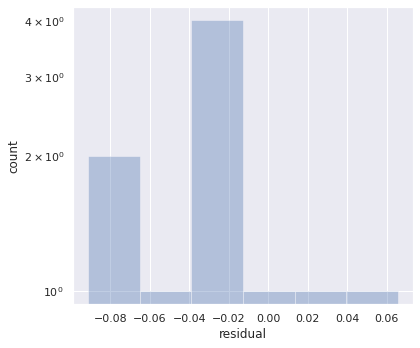

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(pred_res,
             kde=False,
             label='linear fit',
             hist_kws={'alpha': 0.35},
             ax=ax
            )

ax.set(title='',
       xlabel='residual',
       ylabel='count',
       yscale='log'
      )

plt.tight_layout()
plt.savefig('./img/dlumps_stack_hist.pdf', dpi=150, format='pdf')

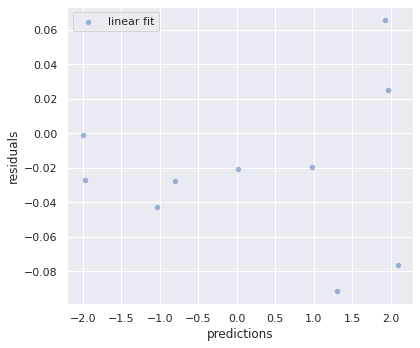

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('./img', exist_ok=True)
sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=dlumps['exp_stack'],
                y=pred_res,
                label='linear fit',
                alpha=0.5,
                ax=ax
               )

ax.set(title='',
       xlabel='predictions',
       ylabel='residuals',
      )

plt.tight_layout()
plt.savefig('./img/dlumps_stack_resplot.pdf', dpi=150, format='pdf')